In [2]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

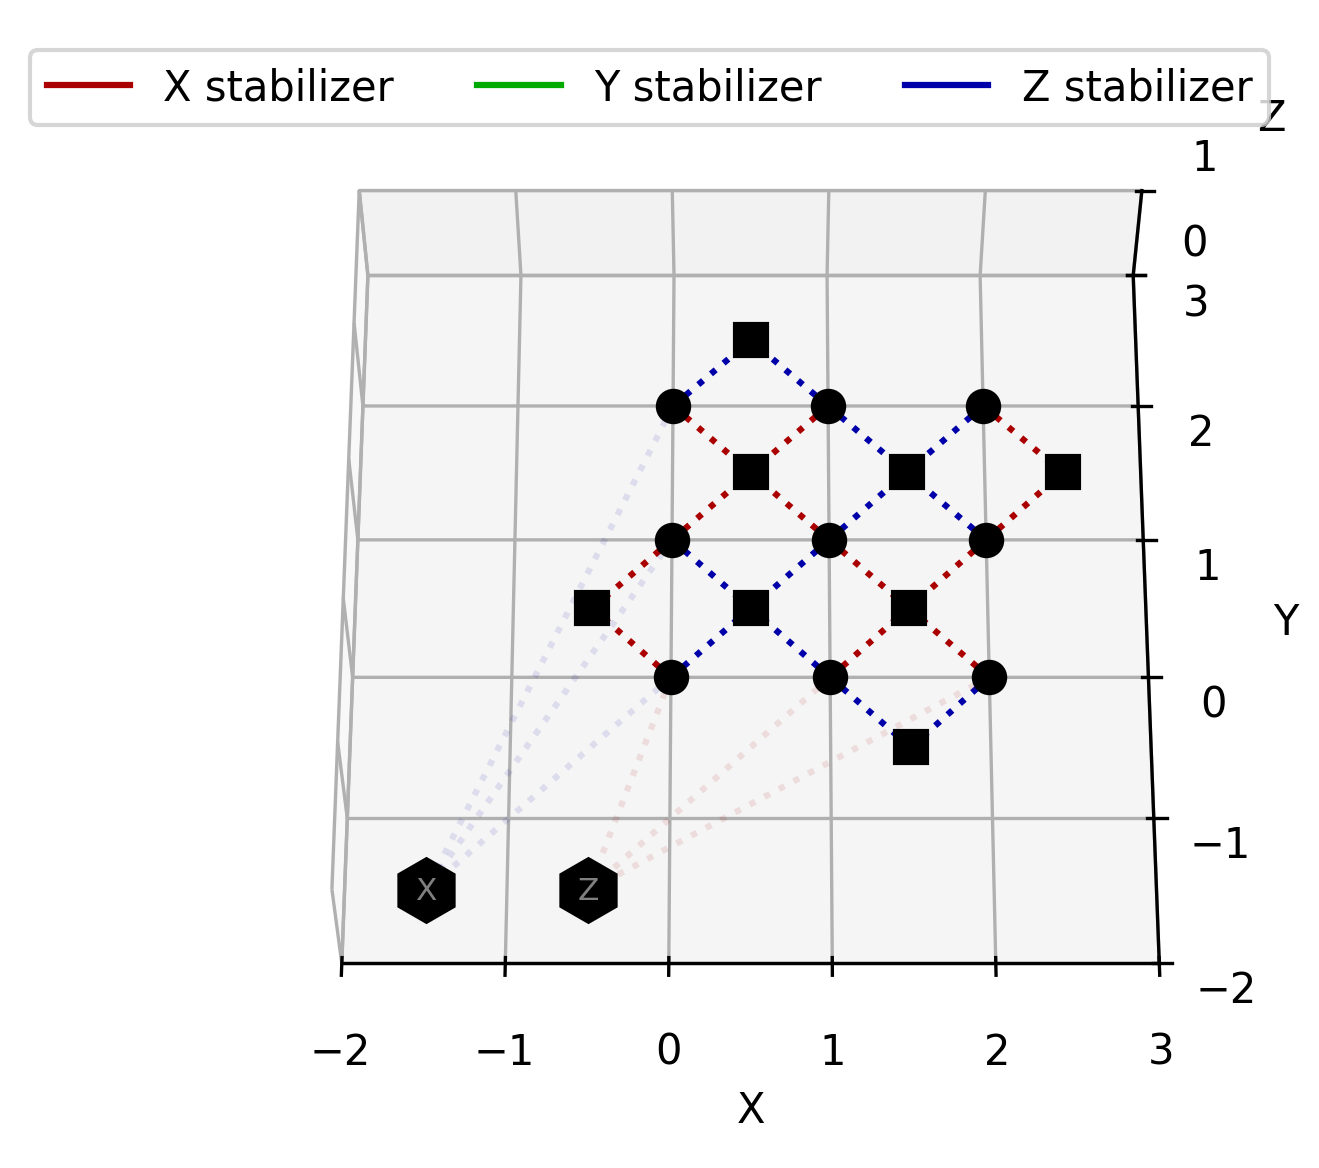

In [3]:
code_distance = 3
qec = QEC(surface_code_data_wls(d=code_distance))
qec.show();

In [4]:
def get_data_batch(key, qec: QEC, error_prob: list, batch_size: int = 1) -> tuple[jnp.ndarray]:
    Mx, My, Mz = qec.transformation_matrix()
    errors = jax_create_error_batch(
        px = error_prob[0],
        py = error_prob[1],
        pz = error_prob[2],
        size = Mx.shape[1],
        batch_size = batch_size,
        key = key
    )
    syndromes_ = jax_get_syndromes_batch(Mx, My, Mz, errors)
    syndromes = syndromes_[:,:-2]
    logits = syndromes_[:,-2:]
    return errors, syndromes, logits

In [5]:
def run_model(syndromes, qec, params) -> tuple[jnp.ndarray]:
    Mx, My, Mz = qec.transformation_matrix()
    NN_raw = NN_batch(syndromes, params)
    NN_correction = NN_raw_to_correction_batch(NN_raw).argmax(axis=1)
    NN_syndromes_ = jax_get_syndromes_batch(Mx, My, Mz, NN_correction)
    NN_syndromes = NN_syndromes_[:,:-2]
    NN_logits = NN_syndromes_[:,-2:]
    return NN_correction, NN_syndromes, NN_logits

In [6]:
def run_mwpm(syndromes, qec) -> tuple[jnp.ndarray]:
    Mx, My, Mz = qec.transformation_matrix()
    check_matrix = jnp.append(Mx[:-2,:], Mz[:-2,:], axis=1)
    matching = Matching(check_matrix)
    
    mwpm_recovery = jnp.array([matching.decode(syndrome) for syndrome in syndromes])
    d = mwpm_recovery.shape[1] // 2
    rec_x, rec_z = mwpm_recovery[:,:d], mwpm_recovery[:,d:]
    mwpm_correction = jnp.where(rec_x, jnp.where(rec_z, 2, 1), jnp.where(rec_z, 3, 0))

    mwpm_syndromes_ = jax_get_syndromes_batch(Mx, My, Mz, mwpm_correction)
    mwpm_syndromes = mwpm_syndromes_[:,:-2]
    mwpm_logits = mwpm_syndromes_[:,-2:]
    return mwpm_correction, mwpm_syndromes, mwpm_logits 

In [7]:
def evaluate_NN_model(params, benchmark_data, qec):
    errors, syndromes, logits = benchmark_data
    # Run the NN model
    NN_correction, NN_syndromes, NN_logits = run_model(
        syndromes=syndromes, 
        qec=qec, 
        params=params
    )
    # Clean up using the mwpm decoder
    mwpm_correction, mwpm_syndromes, mwpm_logits = run_mwpm(
        syndromes=(syndromes + NN_syndromes) % 2,
        qec=qec
    )
    # Calculate statistics
    mistakes_avg = ((syndromes + NN_syndromes) % 2).sum(axis=1).mean()
    logical_error_rate = jnp.not_equal(logits, (NN_logits + mwpm_logits) % 2).any(axis=1).mean()
    print("Based on the provided benchmark data, the model will:")
    print(f"- on average miss {mistakes_avg:.2f} stabilizers.")
    print(f"- result in a logical error {logical_error_rate:.2%} of the time.")

In [10]:
def evaluate_MWPM_model(benchmark_data, qec):
    errors, syndromes, logits = benchmark_data
    # Run the MWPM algorithm
    mwpm_correction, mwpm_syndromes, mwpm_logits = run_mwpm(
        syndromes=syndromes,
        qec=qec
    )
    # Calculate statistics
    mistakes_avg = ((syndromes + mwpm_syndromes) % 2).sum(axis=1).mean()
    logical_error_rate = jnp.not_equal(logits, mwpm_logits).any(axis=1).mean()
    print("Based on the provided benchmark data, the model will:")
    print(f"- on average miss {mistakes_avg:.2f} stabilizers.")
    print(f"- result in a logical error {logical_error_rate:.2%} of the time.")

In [22]:
models = os.listdir("../trained_NN")
models.sort()

# Calculates new key outside of for loop so models for the same code will be evaluated on the same benchmark data
subkey, key = jax.random.split(key)

code_distance_old = -1
for model in models:
    code_distance = int(model[model.find('_D')+2])
    if code_distance != code_distance_old:
        text = f" Distance = {code_distance} "
        print(f"\n\n{text:=^50s}")
        qec = QEC(surface_code_data_wls(d=code_distance))
        benchmark_data = get_data_batch(
            key=subkey, 
            qec=qec, 
            batch_size=10_000, 
            error_prob=[.005, .005, .005]
        )

        base = f"MWPM_SC_D{code_distance}"
        print(f"\n{base:-^50s}\n")
        evaluate_MWPM_model(benchmark_data, qec)

    params = load_NN(f"../trained_NN/{model}")

    print(f"\n\n{model[:-5]:-^50s}\n")
    print(f"- Layers: {[params['weights'][0].shape[1]]+[bias.shape[0] for bias in params['biases']]}")
    evaluate_NN_model(params, benchmark_data, qec)

    code_distance_old = code_distance



================== Distance = 3 ==================

--------------------MWPM_SC_D3--------------------

Based on the provided benchmark data, the model will:
- on average miss 0.00 stabilizers.
- result in a logical error 0.37% of the time.


-------------------NN_SC_D3_V1--------------------

- Layers: [8, 72, 72, 36]
Based on the provided benchmark data, the model will:
- on average miss 0.03 stabilizers.
- result in a logical error 5.81% of the time.


-------------------NN_SC_D3_V2--------------------

- Layers: [8, 72, 72, 36]
Based on the provided benchmark data, the model will:
- on average miss 0.00 stabilizers.
- result in a logical error 5.06% of the time.


-------------------NN_SC_D3_V3--------------------

- Layers: [8, 72, 72, 36]
Based on the provided benchmark data, the model will:
- on average miss 0.00 stabilizers.
- result in a logical error 3.73% of the time.


-------------------NN_SC_D3_V4--------------------

- Layers: [8, 36, 18, 36]
Based on the provided benc